Comentario : *El complemento del trabajo asi como la copia del trabajo puede ser consultado en https://github.com/VicBoxMS/prueba_entropiaIA*

## Librerias a utilizar

In [1]:
#Librerias a utilizar
#Puesto que queremos un trabajo lo mas limpio posible, no imprimiremos los # WARNING: 
import warnings
warnings.filterwarnings("ignore")

#Para los incisos a) b) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#inciso c) 
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.metrics.distance import edit_distance
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#inciso d)
from nltk.corpus import stopwords
from wordcloud import WordCloud

#inciso e)
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing  import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Funciones que utilizaremos

Lo ideal, sería crear un archivo funciones.py y correr la linea de codigo:
> from funciones import *

In [2]:
#Convertir una variable categorica en numerica
def bin_tiempo_respuesta(x):
    #Una respuesta oportuna
    if x=='Yes':
        return 1
    #Una respuesta no oportuna
    elif x=='No':
        return 0
    #A manera de validar posibles errores
    else:
        return -1

#Funcion utilizada para responder el inciso c)
lemmatizer = WordNetLemmatizer()
def correccion_nombres_bancos(x,top_quantil_bancos):
    if x in top_quantil_bancos:
      return x
    mejor_distancia = 10000
    for i in top_quantil_bancos:
        distancia = edit_distance(x,i)
        if distancia < mejor_distancia:
            mejor_distancia=distancia
            correccion = i
    #Si la distancia es muy lejana, digamos un valor de 10, entonces, se regresa 
    #el nombre original
    if mejor_distancia >= 10:
      return x
    else:
      return correccion

#funcion que sustituye los digitos no reportados en el zip como 'X' por el valor 0
def sustituir_x_zip(x):
    parcial=''
    for i in range(len(str(x))):
        try:
            int(x[i])
            parcial+=x[i]
        except:
            parcial+='0'
    return int(parcial)

#Preprocesamiento

- Lectura del archivo
- Modificación de la variable tiempo de respuesta oportuno ('Timely response?')

- Asignar formato de fecha a la columna Fecha en que se recibe la queja ('Date received')

- Volver utilizable la columna codigo postal ('Zip Code')

- La normalizacion de la variable Compañia ('Company') se deja para el inciso c) 

In [4]:
#Ruta del archivo Consumer_Complaints.csv
ruta = 'C:/Users/Victor/Documents/18semestre/EntrevistasdeTrabajo/AplicacionENTROPIA/test_entropia/'
df = pd.read_csv(ruta+'Consumer_Complaints.csv')

#Correccion a la variables tiempo de respuesta oportuno
df['Timely response?'] = df['Timely response?'].apply(bin_tiempo_respuesta)

#Asignar formato de fecha
df['Date received'] =pd.to_datetime(df['Date received'])

#Sustituir los digitos no reportados en el zip como 'X' por el valor 0
df['ZIP code'] = df['ZIP code'].apply(sustituir_x_zip)

# Inciso a)


a. Presenta una o varias estadísticas descriptivas que den una idea de cómo se comportan los datos (en el tiempo, en el espacio, en ambas dimensiones; por nombre del banco, tipo de queja, etc.) Las estadísticas deben acompañarse por una breve explicación que les dé sentido.

### a.1 Sobre los tiempos oportunos de solucion a las quejas

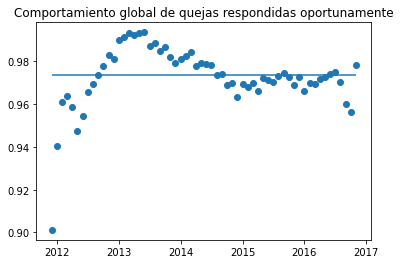

La media global quejas respondidas oportunamente es del 97.35 %


In [5]:
#Agrupamos por mes y año con el objetivo 
periodo_mensual = df['Date received'].dt.to_period("M")
tiempos_de_respuesta = df.groupby(periodo_mensual)['Timely response?'].agg(['sum', 'mean'])
tiempos_de_respuesta = tiempos_de_respuesta.reset_index()

x1 = tiempos_de_respuesta['Date received']
x1 = x1.dt.to_timestamp()
y1 = tiempos_de_respuesta['mean']
media_global = df['Timely response?'].mean()
plt.scatter(x1,y1)
plt.hlines(media_global,min(x1),max(x1))
plt.title('Comportamiento global de quejas respondidas oportunamente')
plt.show()
print('La media global quejas respondidas oportunamente es del', np.round(media_global*100,2), '%')

Los tiempos oportunos de solución eran ligeramente mejor entre el año 2013,2014. La tendencia general de las empresas en los ultimos años parece en mantener un promedio de sus servicios de un 97\%.

Otra estadistica relevante que podemos concluir del grafico anterior es el hecho de que en los ultimos años menos del 5% de los clientes piensa que su respuesta  no fue atendida en un tiempo oportuno.

> Tambien pudieramos comparar la proporcion lo anterior, entre las dos instituciones financieras de nuestro interes.

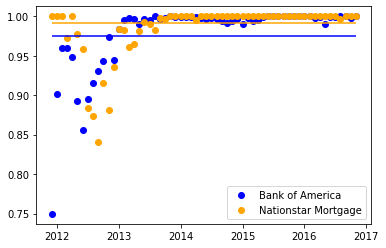

La media de Bank of America 97.47 %
La media de Nationstar Mortgage 99.17 %


In [6]:
##Comparación entre la compañia con el mayor numero de transacciones
##y la comparacion con una compañia que ocupa el puesto numero 10
##en el numero de transacciones

df_america = df[df['Company']=='Bank of America']
df_america = df_america.reset_index()

df_nationstar = df[df['Company']=='Nationstar Mortgage']
df_nationstar = df_nationstar.reset_index()

#Agrupamos por mes y año para el banco de america
periodo_mensual = df_america['Date received'].dt.to_period("M")
tiempos_de_respuesta = df_america.groupby(periodo_mensual)['Timely response?'].agg(['sum', 'mean'])
tiempos_de_respuesta = tiempos_de_respuesta.reset_index()
x1 = tiempos_de_respuesta['Date received']
x1 = x1.dt.to_timestamp()
y1 = tiempos_de_respuesta['mean']
media1 = df_america['Timely response?'].mean()

#Agrupamos por mes y año para Nationstar
periodo_mensual = df_nationstar['Date received'].dt.to_period("M")
tiempos_de_respuesta = df_nationstar.groupby(periodo_mensual)['Timely response?'].agg(['sum', 'mean'])
tiempos_de_respuesta = tiempos_de_respuesta.reset_index()
x2 = tiempos_de_respuesta['Date received']
x2 = x2.dt.to_timestamp()
y2 = tiempos_de_respuesta['mean']
media2 = df_nationstar['Timely response?'].mean()

###Mostraremos la puntuación promedio por año comparar
###para cada banco en este sentido
plt.scatter(x1,y1,color='blue',label='Bank of America')
plt.scatter(x2,y2,color='orange',label='Nationstar Mortgage')
plt.hlines(media1,min(x1),max(x1),color='blue')
plt.hlines(media2,min(x1),max(x1),color='orange')
plt.legend()
plt.show()
print('La media de Bank of America', np.round(media1*100,2), '%')
print('La media de Nationstar Mortgage', np.round(media2*100,2), '%')

> El banco Nationstar Mortgage tiene proporción de tiempo de respuesta más optima que Bank of America

### a.1.1 ¿Existe una relación entre el numero de quejas y el tiempo de respuesta oportuno?

In [8]:
top=25 #Numero de bancos a considerar
nombre_bancos, conteo_nombres = np.unique(df['Company'],return_counts=True)
orden_desc = conteo_nombres.argsort()[::-1]
top_transacciones_bancos = nombre_bancos[orden_desc][:top]

#bancos diferentes identificados
len(nombre_bancos) #3933 bancos diferentes

#
titles = top_transacciones_bancos
df_top10 = df.query("Company in @titles")
resumen = df_top10.groupby('Company')['Timely response?'].agg(['count', 'mean'])
resumen.sort_values(by='count',ascending=False)
resumen.corr()

count      mean
count  1.000000 -0.438257
mean  -0.438257  1.000000

> Si consideramos los 25 bancos con el mayor numero de transacciones podemos notar que a menor de numero de transacciones, los bancos pueden  resolver a tiempo las inquietudes reportadas, lo que se traduce en una taza de respuesta oportuna mas alta.

### a.1.2 ¿Cual es el tiempo de respuesta a las quejas reportadas?

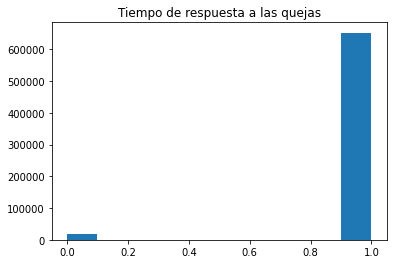

In [9]:
plt.hist(df['Timely response?'])
plt.title('Tiempo de respuesta a las quejas')
plt.show()

> Nos damos cuenta que la mayoria de las quejas se resuelven en un día, sin embargo algunas quejas parecen resolverse inmediatamente, en ese sentido.

¿Cuales son los temas que se resuelven mas rapido?


In [10]:
df_temas_x_dias = pd.crosstab(index=df['Product'], columns=df['Timely response?'])
#,0:'0 dias',
df_temas_x_dias=df_temas_x_dias.apply(lambda r: r/r.sum(),axis=1)#.reset_index()
df_temas_x_dias = df_temas_x_dias.rename(columns={0:'0 dias',1:'1 dia'})
df_temas_x_dias.sort_values(by='0 dias',ascending=False)

Timely response?           0 dias     1 dia
Product                                    
Virtual currency         0.142857  0.857143
Payday loan              0.105307  0.894693
Other financial service  0.095533  0.904467
Debt collection          0.072499  0.927501
Consumer Loan            0.034093  0.965907
Mortgage                 0.021676  0.978324
Money transfers          0.021186  0.978814
Bank account or service  0.017454  0.982546
Student loan             0.014179  0.985821
Prepaid card             0.012930  0.987070
Credit card              0.009366  0.990634
Credit reporting         0.001493  0.998507

> Podemos ver que que para los tramites Moneda virtual ('Virtual Currency') y Préstamo a corto plazo'('payday loan'), es más comun que los tramites puedan ser resuelta en 0 días 

### a.3 ¿Cual es el medio de comunicación para hacer llegar las inquietudes ?
###      ¿Como ha evolucionado el medio de comunicación entre el usuario y las empresas?


In [11]:
df_cruza = pd.crosstab(df['Date received'],df['Submitted via']).reset_index()
periodo_anual = df_cruza['Date received'].dt.to_period("Y")
#df_cruza.groupby(periodo_anual).sum().sum()
df_cruza.groupby(periodo_anual).sum().apply(lambda r : r/r.sum(),axis=1)

Submitted via     Email       Fax     Phone  Postal mail  Referral       Web
Date received                                                               
2011           0.003937  0.003937  0.085827     0.018504  0.313780  0.574016
2012           0.002127  0.013231  0.087358     0.063147  0.386006  0.448131
2013           0.001395  0.019108  0.087696     0.073864  0.260372  0.557565
2014           0.000111  0.015148  0.067086     0.073533  0.154349  0.689773
2015           0.000047  0.012722  0.060937     0.056281  0.127811  0.742200
2016           0.000048  0.013473  0.065228     0.063412  0.127440  0.730399

> Independientemente del año que se quiera considerar, vemos que la mayoria de las situaciones reportadas ocurren por medio de la web. Podemos ver que en los ultimos años registrados  la comunicación via internet ha tomado mas terreno y la que ha perdido mas impulso es la etiquetada como 'Referral'. El e-mail por su parte es quien tiene la menor participación para el año 2016 con un porcentaje de $0.000048*100=0.0048\% $.


# Inciso b) 

b. Como parte de la pregunta anterior, o en adición, crea una o varias visualizaciones que
pienses que es importante para entender la base de datos. Sé selectiv@, de modo que tu(s)
visualizacion(es) cuenten una historia con los datos. Puedes usar visualizaciones dinámicas
(plotly, bokeh, etc.) o estáticas (matplotlib, seaborn, plotnine etc.)

## b.1  ¿Que regiones estan involucradas en nuestra base de datos?

Una pregunta natural que uno se hace particularmente para este  ¿De donde provienen las quejas que estan involucradas en nuestra base de datos?, de esta forma conocemos el alcance que tenemos y la generalización que podemos obtener.

In [12]:
#mapa
import plotly.express as px
from urllib.request import urlopen
import json

with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ny_new_york_zip_codes_geo.min.json') as response:
    zipcodes = json.load(response)

In [13]:
#Filtramos los estados que tienen un registro no vacio o erroneo
df_mapa = df[~df['State'].isna()]['State']

#Realizamos un conteo de los estados y convertimos en formato de dataframe
estados, conteo = np.unique(df_mapa,return_counts=True)
estados, conteo = pd.DataFrame(estados).rename(columns = {0:'estados'}) ,pd.DataFrame(conteo).rename(columns = {0:'conteo'})
df_conteo_x_estados = pd.concat([estados,conteo],axis=1)

In [14]:
#Imprimimos la figura para entender que estados componen nuestro conjunto de datos
#y entender de donde provienen el mayor numero de quejas
fig = px.choropleth(df_conteo_x_estados,
                    locations='estados',
                    color='conteo',
                    color_continuous_scale='spectral_r',
                    hover_name='estados',
                    locationmode='USA-states',
                    scope='usa')
fig.show()

> No es dificil ver que la mayor parte de las inquietudes provienen de estados como CALIFORNIA y FLORIDA, habría que investigar el porque de la situación posiblemente se deba unicamente a un mayor numero de clientes en esas zonas o bien, la tasa de quejas podría ser muy alta, lo que llevaria a concluir que no se está dando un servicio adecuado.

# c)

c. Utilizando un algoritmo de “edit-distance” o alguno otro que consideres pertinente, normaliza los nombres de los bancos y genera un gráfico de barras que muestre la frecuencia de
quejas por banco.

*Solucion* :

Una vez importado edit_distance y complementandolo con la funcion correccion_nombres_bancos, proponemos la siguiente idea para normalizar los nombres:


1. Si el nombre de un banco se repite muchas veces sería logico que el nombre esta inscrito por lo que hay que buscar un numero a partir del cual considerar que el nombre no está escrito de manera correcta, para nuestro ejemplo, nosotros asumiremos que el 10\% de los nombres está bien escrito.

2. En este caso nuestro punto de corte en el quantil 0.1, nos lleva a pensar que aquellas instituciones de las cuales tenemos menos de 90 son posiblemente duplicados, habría que hacer un analisis más detallado para tomar la decisión.
Asumiremos que si una institucion tiene mas de 90 registros, el nombre está
escrito de manera correcta.

3. De un total de 3933 nombres unicos de bancos, el corte de 90 transacciones o menos nos dice que de esos 3933 nombres solo 393 son 'correctos' mientras que 3540 son posibles errores.


In [15]:
#Realizamos el conteo de instituciones/bancos #3933 bancos diferentes
nombre_bancos, conteo_nombres = np.unique(df['Company'],return_counts=True)


#Por el numero de transacciones, realizamos un corte en el quantil 0.9
#lo que es un valor approximado de 90
quantil_interes = np.quantile(conteo_nombres,0.9)

#La funcion correccion_nombres_bancos utiliza un lematizador con el objetivo de 
#simplificar la palabras, eliminar nombres en plural por ejemplo.

#Ordenamos por numero de registros y la variable 
#top_quantil_bancos contiene el nombre de aquellos bancos que creemos estan correctos

orden_desc = conteo_nombres.argsort()[::-1]
num_bancos_quantil = int(len(nombre_bancos)*0.1)
top_quantil_bancos = nombre_bancos[orden_desc][:num_bancos_quantil]

#creamos una copia para comparar la normalizacion realizada
df_normalizar_bancos = df.copy()

In [16]:
%time correcciones = [correccion_nombres_bancos(l,top_quantil_bancos) for l in df['Company'][:1000]]
print('Se estima un tiempo de ejecucion de ',(( (len(df['Company'])/1000)*9)/60)/60 ,'horas')

Wall time: 9.02 s
Se estima un tiempo de ejecucion de  1.6764949999999998 horas


In [1]:
#Aplicamos la funcion correccion_nombres_bancos, pasando como argumento, el nombre
#de los bancos que creemos son correctos

#df_normalizar_bancos['Company'] = df_normalizar_bancos['Company'].apply(lambda x : correccion_nombres_bancos(x,top_quantil_bancos=top_quantil_bancos))

El tiempo de ejucion de la correcion se estima en 1.5 horas por lo que hay que buscar la manera de optimizar nuestro codigo.

### c.2 A continuación presentamos el top 10 de bancos con mayor numero de quejas, antes y despues de la normalizacion.

In [17]:
#Preparacion de los datos para el dataframe
nombre_bancos, conteo_nombres = np.unique(df['Company'],return_counts=True)
nombre_bancos = pd.DataFrame(nombre_bancos).rename(columns={0:'nombre_bancos'})
conteo_nombres = pd.DataFrame(conteo_nombres).rename(columns={0:'conteo_bancos'})
df_antes = pd.concat([nombre_bancos,conteo_nombres],axis=1)
df_antes = df_antes.sort_values(by='conteo_bancos',ascending=False)

#Grafica de datos
top=10
fig = px.bar(df_antes[:top], y='conteo_bancos', x='nombre_bancos', text_auto='.2s',
            title="Quejas de usuarios por bancos [Top10 Antes de Normalizar]")
fig.show()

In [18]:
#No se optimizo la función a tiempo por lo que no se anexa una comparación

"""
#Preparacion de los datos para el dataframe
nombre_bancos, conteo_nombres = np.unique(df_normalizar_bancos['Company'],return_counts=True)
nombre_bancos = pd.DataFrame(nombre_bancos).rename(columns={0:'nombre_bancos'})
conteo_nombres = pd.DataFrame(conteo_nombres).rename(columns={0:'conteo_bancos'})
df_despues = pd.concat([nombre_bancos,conteo_nombres],axis=1)
df_despues = df_antes.sort_values(by='conteo_bancos',ascending=False)

#Grafica de datos
top=10
fig = px.bar(df_despues[:top], y='conteo_bancos', x='nombre_bancos', text_auto='.2s',
            title="Quejas de usuarios por bancos [Top10 Despues de Normalizar]")
fig.show()
"""

'\n#Preparacion de los datos para el dataframe\nnombre_bancos, conteo_nombres = np.unique(df_normalizar_bancos[\'Company\'],return_counts=True)\nnombre_bancos = pd.DataFrame(nombre_bancos).rename(columns={0:\'nombre_bancos\'})\nconteo_nombres = pd.DataFrame(conteo_nombres).rename(columns={0:\'conteo_bancos\'})\ndf_despues = pd.concat([nombre_bancos,conteo_nombres],axis=1)\ndf_despues = df_antes.sort_values(by=\'conteo_bancos\',ascending=False)\n\n#Grafica de datos\ntop=10\nfig = px.bar(df_despues[:top], y=\'conteo_bancos\', x=\'nombre_bancos\', text_auto=\'.2s\',\n            title="Quejas de usuarios por bancos [Top10 Despues de Normalizar]")\nfig.show()\n'

# d)

d. ¿De qué temas hablan las quejas?

In [19]:
productos , conteo_productos = np.unique(df['Product'],return_counts=True)
orden_desc = conteo_productos.argsort()[::-1]
orden_desc
df_conteo_productos = pd.DataFrame([productos[orden_desc],conteo_productos[orden_desc]]).T
df_conteo_productos.rename(columns={0:'productos',1:'conteo_productos'})

productos conteo_productos
0                  Mortgage           210324
1           Debt collection           124236
2          Credit reporting           119195
3               Credit card            79007
4   Bank account or service            76084
5             Consumer Loan            26604
6              Student loan            21651
7               Payday loan             4786
8           Money transfers             4720
9              Prepaid card             3171
10  Other financial service              806
11         Virtual currency               14

Son quejas realizadas por clientes hacia productos y servicios financieros ,
algunos de los principales temas/productos son:

- Hipotecas
- Cobro de deudas
- Informes de creditos
- Tarjetas de creditos
- Cuentas bancarias o servicios


Otra forma de visualizar el contenido es tomar la información de las quejas y elaborar una nube de palabras

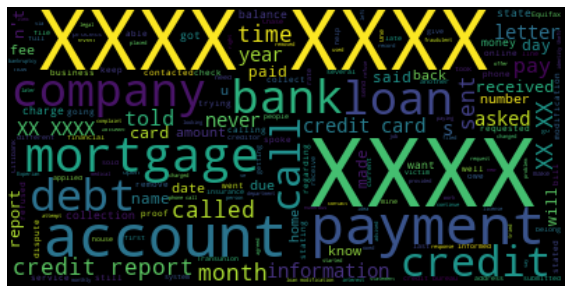

In [25]:
#stop_words contiene todas las palabras secundarias que no son de nuestro quantil_interes
#al momento de generar una bolsa de palabras/nube de palabras.
stop_words = stopwords.words('english')
stop_words.append('XXXX')
stop_words.append('xxxx')
nonan = ~df['Consumer complaint narrative'].isna()
comentarios_clientes = df['Consumer complaint narrative'][nonan]
comentarios_clientes_cortados = [i[:500] for i in comentarios_clientes]

comentarios_unidos = comentarios_clientes_cortados[0]+comentarios_clientes_cortados[1]
for i in range(2,200):
  comentarios_unidos+=comentarios_clientes_cortados[i]

wordcloud = WordCloud().generate(comentarios_unidos)
# imagen generada a partir de toda la informacion
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos ver que en conjunto los textos hablas sobre tarjetas, creditos, tasas de amortizacion, ademas de que por cuestiones de confidencialidad hay mucha
informacion anonimizada. Otra perspectiva que pudieramos tener de los datos es obtener una bolsa de palabras por cada tema. (Por cuestiones de tiempo se omite).

# e)

e. Desarrolla un modelo de aprendizaje no supervisado para entender una dimensión de los datos en la que son claramente clusterizables

&nbsp;
&nbsp;

Para esta parte, decidimos utilizar la columna **Codigo Postal ('Zip Code')** que corresponde al codigo postal donde se realiza el reporte, la información puede ser utilizada para sustituir o *complementar la variable Estado ('State')* ya que al clusterizar podemos encontrar similitudes entre algunos estados o estudiar mejor la frontera que existe entre ellos.


In [26]:
df_tsne = df[['State','ZIP code']][~df['State'].isna()]
df_tsne = df_tsne.reset_index()
estados = df_tsne['State']
X = np.array(df_tsne['ZIP code'])
X = X.reshape(-1,1)
X = X[:10000]

X = StandardScaler().fit_transform(X)
estados = estados[:10000]

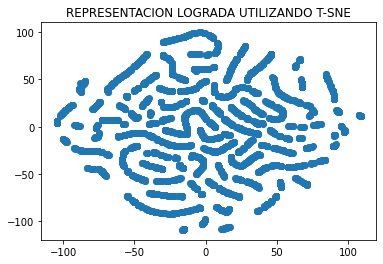

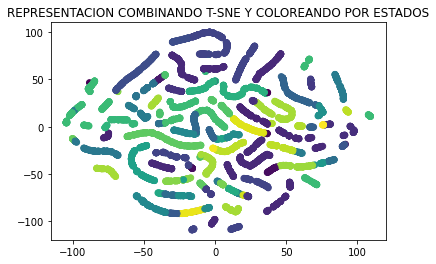

In [29]:
n_a_graficar = 5000
etiquetas_estados = LabelEncoder().fit_transform(df_tsne['State'])
X_embedded = TSNE(n_components=2,init='random',random_state=0).fit_transform(X)
plt.scatter(X_embedded[:n_a_graficar,0],X_embedded[:n_a_graficar,1])
plt.title('REPRESENTACION LOGRADA UTILIZANDO T-SNE')
plt.show()
plt.scatter(X_embedded[:n_a_graficar,0],X_embedded[:n_a_graficar,1],c=etiquetas_estados[:n_a_graficar])
plt.title('REPRESENTACION COMBINANDO T-SNE Y COLOREANDO POR ESTADOS')
plt.show()

A partir de la tecnica t-sne podemos ver una cierta agrupación de los codigos postales, que de hecho coincide de manera parcial con los estados, podemos ver segmentos de puntos del mismo color, lo que hace referencia a que pertenecen a un unico estado.

Ahora bien, sobre dicha proyeccion realizada, lo ideal sería definir un numero de clusters y estudiar la posibilidad de utilizar los clusters generados como una variable predictora.


> Para no definir Apriori un numero de clusters, podriamos ocupar un algoritmo DBSCAN, pero es comun que los clusters que se formen de este algoritmo sean circulares, almenos para un espacio bidimensional, los resultados de este algoritmo se omiten en el presente reporte

> Por lo que podemos ver de la tecnica t-sne, estariamos pensando en que existe una conexion entre elementos del cluster, por lo que haremos un grafo que nos ayude a entender las conexión y aplicaremos un cluster aglomerativo a t-sne considerando las distancias de vecinos mas cercanos consideraremos conexiones completas y simples.

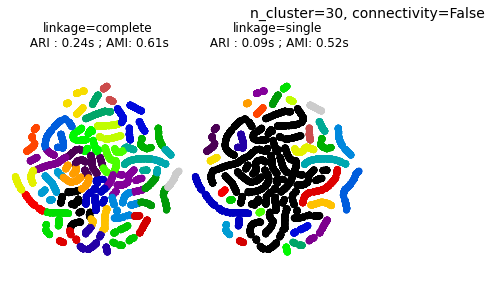

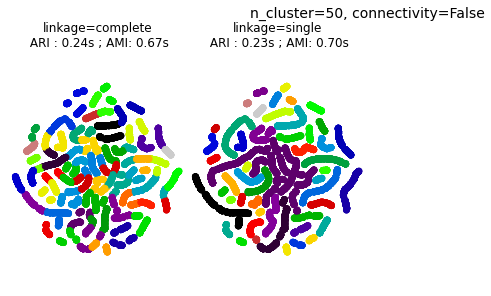

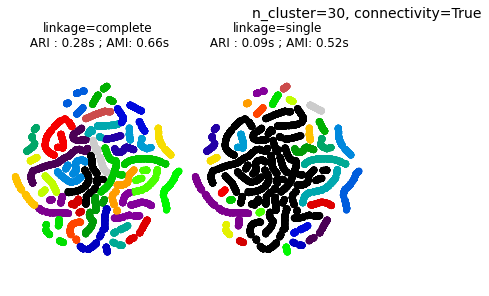

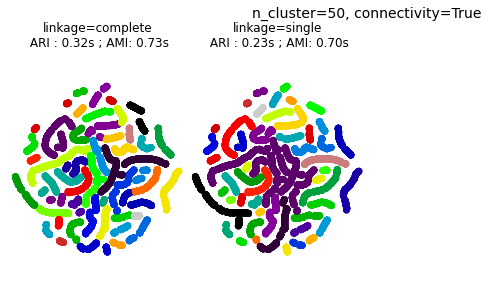

In [28]:
knn_graph = kneighbors_graph(X_embedded, 30, include_self=False)
for connectivity in (None,knn_graph):
    for n_clusters in (30, 50):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(("complete", "single")):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(
                linkage=linkage, connectivity=connectivity, n_clusters=n_clusters
            )
            t0 = time.time()
            model.fit(X_embedded)
            elapsed_time = time.time() - t0
            ari = metrics.adjusted_rand_score(etiquetas_estados[:len(model.labels_)], model.labels_)
            ami = metrics.adjusted_mutual_info_score(etiquetas_estados[:len(model.labels_)], model.labels_)
            plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title(
                "linkage=%s\n ARI : %.2fs ; AMI: %.2fs" % (linkage,ari,ami),
                fontdict=dict(verticalalignment="top"),
            )
            plt.axis("equal")
            plt.axis("off")
            plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
            plt.suptitle(
                "n_cluster=%i, connectivity=%r"
                % (n_clusters, connectivity is not None),
                size=14,
            )
plt.show()

De acuerdo a las metricas ari y ami, y bajo el supuesto de que atraves del codigo postal, podemos encontrar clusters que represen a los estados, los mejores modelos de clusterización parecen ser los que consideran un enlace simple ('single') independientemente de si considere o no la conectividad (connectivity).

# f)

f. Desarrolla un modelo de machine learning que prediga el tipo de producto con base en el texto. Puedes usar la técnica que desees, pero debes explicar qué métricas de evaluación usas para determinar tu elección del modelo.

> Por cuestiones de tiempo evitaremos modelos como bag-of-words y tfdi y apostaremos directamente por modelos de transformers, utilizaremos un modelo previamente entrenado para crear los embeddings y tambien utilizaremos ajuste fino.

> Por las capacidades de mi computadora, esta ultima parte, la haremos directamente en google collab.


> La variable respuesta será el producto ( y = 'Product' ) y para realizar la prediccion utilizaremos la informacion disponible en la variables Narrativa del consumidor ( X = 'Consumer complaint narrative' ).

1. Utilizaremo el modelo distilbert-base-uncased para realizar ingenieria de caracteristicas (extraccion de caracteristicas) y posteriormente ingresar a 2 modelos de machine learning regresión logistica y bosques aleatorios, ambos elegidos por la rapidez con la que se puede entrenar un modelo.

2. La segunda parte de nuestra propuesta consiste en un ajuste fino del modelo distilbert a nuestros datos, con ello esperamos mejorar nuestra metrica de interes.

In [20]:
!pip install datasets
!pip install transformers

In [ ]:
#funciones que utilizamos

#graficar matriz de confusion
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

#Retorna las metricas accuracy y f1
def compute_metrics(pred):
  label_prediction = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(label_prediction, preds, average="macro")
  acc = accuracy_score(label_prediction, preds)
  return {"accuracy": acc, 
          "f1": f1
          }

In [ ]:
#Libreria
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from transformers import AutoTokenizer, DistilBertTokenizer, \
                         AutoModel, AutoModelForSequenceClassification, \
                         Trainer, TrainingArguments
from torch.nn.functional import cross_entropy
from datasets import list_datasets
from datasets import load_dataset
from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import train_test_split

from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from sklearn.metrics import classification_report

from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
##preprocesando texto
ruta = '/content/drive/MyDrive/entropia/'
df = pd.read_csv(ruta+'Consumer_Complaints.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#especificamos las columnas que utilizaremos asi como 
#
df_non_nan=df[df['Consumer complaint narrative'].isna()==False]
df_non_nan = df_non_nan.reset_index()
label = list(df_non_nan['Product'])
text = list(df_non_nan['Consumer complaint narrative'])
lencoder = LabelEncoder()
label = lencoder.fit_transform(label)

In [ ]:
#Optamos por recortar el numero de caracteres a 220, por los tiempos de entrenamiento 
#que implica cadenas de caracteres largos
texto_cortado = [i[:220] for i in text]

#Creamos 3 conjuntos de datos train-validation-test
x_train, x_validation, y_train, y_validation = train_test_split(texto_cortado, label, test_size=0.5, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation, y_validation, test_size=0.5, random_state=42)

d = {'train':Dataset.from_dict({'text':x_train,'label':y_train}),
     'validation':Dataset.from_dict({'text':x_validation,'label':y_validation}),
     'test':Dataset.from_dict({'text':x_test,'label':y_test}),        
     }

#Creamos el dataset
df_temas = DatasetDict(d)
train_ds = df_temas["train"]
labels = df_temas["train"].features["label"]
labels=lencoder.classes_

In [ ]:
#Descargamos el modelo que utilizaremos y activamos el tokenizador
#
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

print(tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names)
#Estamos frente a un modelo con un vocabulario de 30522 y que desemboca en 512 caracteristicas

30522 512 ['input_ids', 'attention_mask']


In [ ]:
#Definimos una funcion para tokenizar por batchs.
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

#Tokenizamos todos nuestros datos por lo que las caracteristicas
#'input_ids' y 'attention_mask' estan presentes en el data set
df_temas_encoded = df_temas.map(tokenize, batched=True, batch_size=None)
df_temas_encoded["train"].column_names

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Fine-tuning transformers

In [ ]:
#Especificamos etiquetas
#numero de clases y el modelo
labels=lencoder.classes_
num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

from huggingface_hub import notebook_login
notebook_login()

#Especificamos los parametros del entrenamiento 
batch_size = 64
logging_steps = len(df_temas_encoded["train"])
model_name = f"{model_ckpt}-finetuned-df-temas"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=df_temas_encoded["train"],
    eval_dataset=df_temas_encoded["validation"],
    tokenizer=tokenizer
)

In [ ]:
#Comenzar el entrenamiento
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


TrainOutput(global_step=1794, training_loss=0.6689913780527105, metrics={'train_runtime': 1447.4522, 'train_samples_per_second': 79.245, 'train_steps_per_second': 1.239, 'total_flos': 3799312556507136.0, 'train_loss': 0.6689913780527105, 'epoch': 2.0})

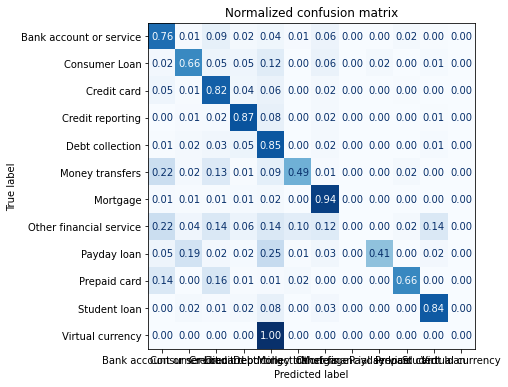

                         precision    recall  f1-score   support

Bank account or service       0.82      0.76      0.79      2615
          Consumer Loan       0.74      0.66      0.69      1622
            Credit card       0.78      0.82      0.80      3388
       Credit reporting       0.86      0.87      0.87      5446
        Debt collection       0.83      0.85      0.84      7275
        Money transfers       0.72      0.49      0.58       289
               Mortgage       0.90      0.94      0.92      6189
Other financial service       0.00      0.00      0.00        49
            Payday loan       0.64      0.41      0.50       326
           Prepaid card       0.71      0.66      0.68       268
           Student loan       0.83      0.84      0.83      1208
       Virtual currency       0.00      0.00      0.00         1

               accuracy                           0.84     28676
              macro avg       0.65      0.61      0.63     28676
           weighted avg

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
preds_output = trainer.predict(df_temas_encoded["test"])
preds_output.metrics
y_valid = df_temas['test']['label']
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)
print(classification_report(y_valid,y_preds,target_names=labels))

> Tratar de adaptar nuestros datos a las capas finales del modelo de transformers, mejoró nuestra metrica de interes, pasando de **0.53 a 0.62**.

> Por otra parte el accuracy paso de un valor de **0.74 a 0.83**

> La matriz de confusión muestra valores mas estables para lo que es nuestro ultimo modelo.

Creemos que es un modelo que puede mejorar de manera inmediata al alimentar con mas información los temas que tiene pocas observaciones como lo son 'Other financial service' o   'Virtual currency'.